<font color=gray>ADS Sample Notebook.

Copyright (c) 2020, 2021 Oracle, Inc.  All rights reserved.
Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.
</font>

***
# Working with the Autonomous Databases
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle Cloud Infrastructure Data Science Team </font></p>

---

## Overview:

Data scientists often need to access information stored in databases. This notebook demonstrates how to connect to an Oracle Autonomous Database (ADB) and perform popular CRUD operations. Oracle offers two type of ADB, the Autonomous Data Warehouse (ADW) and the Autonomous Transaction Processing (ATP) databases. In general, there are no differences in how a connection is made to these different types of databases.

This notebook introduces how to pull data from an ADB into a notebook. It also demonstrates how to write generic SQL queries in the notebook, and several ways to connect.

**Important:**

Placeholder text for required values are surrounded by angle brackets that must be removed when adding the indicated content. For example, when adding a database name to `database_name = "<database_name>"` would become `database_name = "production"`.

---


## Prerequisites:
- An existing Autonomous Database, either an ADW or ATP.
- A user account on the ADB.
- If the ADB is accessible over the public internet, the notebook requires permissions to egress to the internet.
- Ensure the tenancy is [configured to use the Vault](https://docs.cloud.oracle.com/en-us/iaas/Content/KeyManagement/Tasks/managingvaults.htm).

This notebook is intended for beginners that need to connect to an ADB. It uses examples based on Python libraries and also basic SQL commands. Basic knowledge of the Python and SQL languages is necessary.

---

## Business Uses:

The Accelerate Data Science (ADS) SDK can load data from various resources and in a wide range of formats. The ADB is one of the most frequently used resources. For example, a business may have an existing dataset that is stored in ADW or ATP that could be loaded and explored with a notebook.
 
 ---
 
 ## Objectives:

 - <a href='#setup'>Setting Up the Notebook Session to Access ADB</a>
     - <a href='#setup_01'>Go to the database console</a>
     - <a href='#setup_02'>Select the database</a>
     - <a href='#setup_03'>Open DB Connection</a>
     - <a href='#setup_04'>Download the wallet</a>
     - <a href='#setup_05'>Rename the wallet</a>
     - <a href='#setup_06'>Upload the wallet to the notebook</a>
     - <a href='#setup_07'>Import the wallet</a>
     - <a href='#setup_08'>Creating credentials</a>
     - <a href='#setup_09'>Store Credentials</a>
         - <a href='#setup_vault'>Oracle Cloud Infrastructure Vault</a>
         - <a href='#setup_repository'>Repository</a>
     - <a href='#setup_10'>Testing the internet connection</a>
     - <a href='#setup_11'>Testing the connection to the ADB</a>
     - <a href='#setup_12'>Connect to Autonomous Database</a>
 - <a href='#load'>Loading an ADB Table as an `ADSDataset` Object</a>
 - <a href='#run'>Running an SQL Query on ADB Using `SQLAlchemy` and `Pandas`</a>
 - <a href='#create'>Creating a Table with `SQLAlchemy` and `Pandas` and Updating It</a>
 - <a href='#query'>Querying Data from ADB using `cx_Oracle`</a>
 - <a href='#ref'>References</a>
---

In [ ]:
import cx_Oracle
import logging
import os
import pandas as pd
import warnings

from ads.database import connection 
from ads.database.connection import Connector
from ads.dataset.factory import DatasetFactory
from ads.vault.vault import Vault
from sqlalchemy import create_engine
from urllib.request import urlopen

warnings.filterwarnings("ignore", category=DeprecationWarning) 
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

<a id='setup'></a>
# Setting Up the Notebook Session to Access ADB

To access ADB, (ADW or ATP databases) from the notebook environment, the database's wallet and user credentials are needed. The wallet is a ZIP file that contains connection information and the encryption keys that are needed to establish a secure connection to the database.

The following instructions are for the ADW though the steps are identical for an ATP database. 

**Note: The Oracle Cloud Infrastructure Console is constantly evolving. While we strive to keep the images up to date, they are representative only.**

Upload the wallet to the notebook. The wallet can be obtained from your database administrator, Oracle Cloud Infrastructure API, Oracle CLI, or from the Console. In this example, it is downloaded from the Console.

<a id='setup_01'></a>
## 1. Go to the database console

In the Console, navigate to the **Autonomous Data Warehouse** or **Autonomous Transaction Processing** section. 

<a id='setup_02'></a>
## 2. Select the database

Select the database to connect to. If one does not exist, one may need to be created. 

<a id='setup_03'></a>
## 3. Open DB Connection

On the main page of the database, click **DB Connection** on an active database:

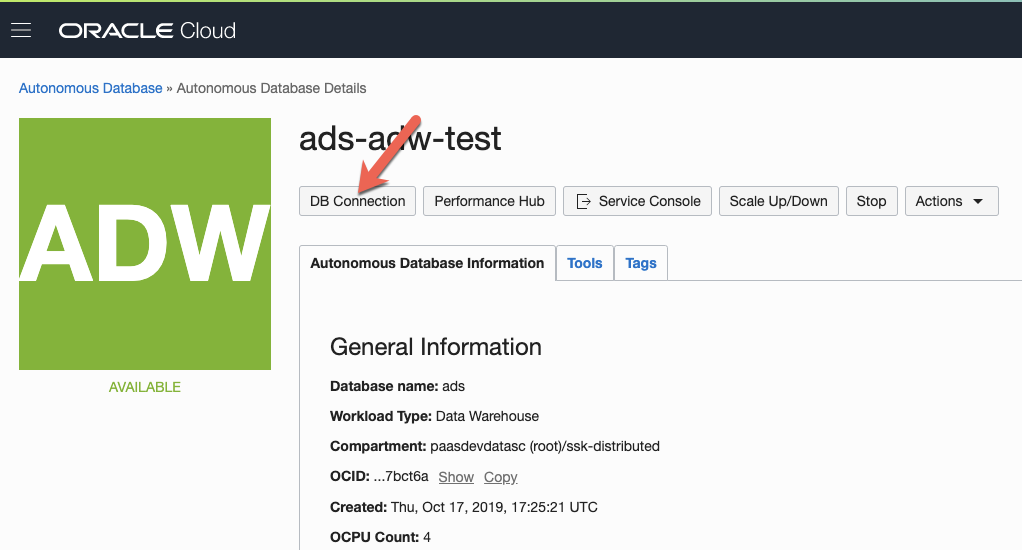

<a id='setup_04'></a>
## 4. Download the wallet

Click **Download Wallet**. You are asked to create a password. This password is used to access resources from some systems though it is not needed in the notebook.

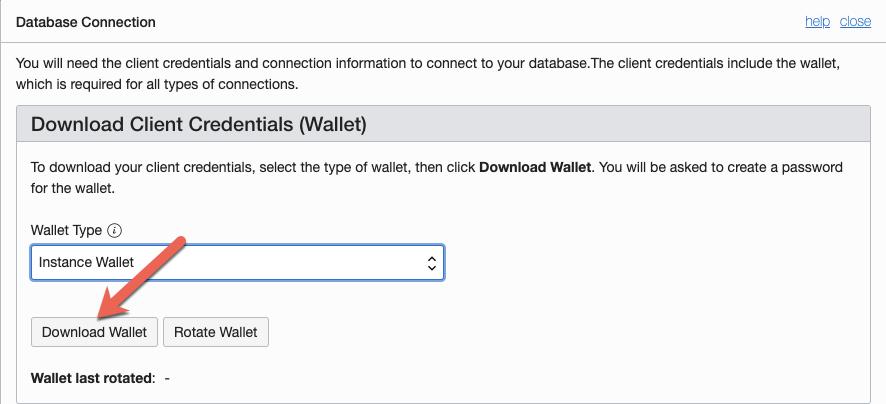

<a id='setup_05'></a>
## 5. Rename the wallet

It has a name like `Wallet_<database_name>.zip`. For example, `Wallet_production1.zip`. Note the database name and the capitalization because it is used in step 7.

<a id='setup_06'></a>
## 6. Upload the wallet to the notebook

A script is used to configure the connection. This script assumes that the file has the format given in the preceding step and that the file exists in the `/home/datascience` directory. To upload the wallet, drag and drop it into the file browser, or click upload:

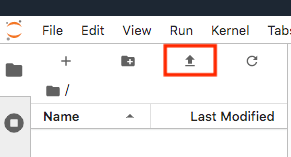

<a id='setup_08'></a>
## 7. Creating credentials

`ADS` methods for working with credentials uses a Python `dict` to store the key/value pairs. Therefore, any arbitrary values can be stored. Below is a common use case to store credentials to access an Oracle Autonomous Database.

In the `credential` variable, the following values can be updated to store the desired authentication information; `<database_name>`, `<user_name>`, and `<password>`.

In [ ]:
# Sample credentials that are going to be stored.
credential = {'database_name': '<tns_name>', 
              'username': '<user_name>', 
              'password': '<password>',
              'database_type':'oracle'}

<a id='setup_09'></a>
## 8. Store Credentials

The `ADS` library supports two mechanisms for storing credentials. It is best practice to store credentials outside of the notebook. Therefore, the preferred method is to use the Oracle Cloud Infrastructure Vault. If your tenancy is not configured to use the Vault, it is recommended that it be configured as this is the most secure method. If you cannot or prefer not to use the Vault, `ADS` supports storing the credentials on the local drive using the repository. The repository is a general-purpose mechanism for storing key/value pairs. The data is not encrypted and therefore is accessible by anyone with access to the notebook session.

<a id='setup_vault'></a>
### Oracle Cloud Infrastructure Vault

Ensure that the tenancy is [configured to use the Vault](https://docs.cloud.oracle.com/en-us/iaas/Content/KeyManagement/Tasks/managingvaults.htm).

The `ADS` vault methods assume that the data being stored is in a dictionary. Internally it stores it as an encoded JSON object.

In the following cell, update `<vault_id>` with the OCID for the vault that you wish to connect to. To encrypt/decrypt the data an encryption key is needed. This key is part of the vault. If one does not exist you may have to create it. Update `<key_id>` with the OCID of the encryption key.

In [ ]:
vault_id = "<vault_id>"
key_id = "<key_id>" 

The following cell obtains a handle to the vault and creates a secret. It returns the OCID to the secret so that it can be accessed.

In [ ]:
# Create a secret
if vault_id != "<vault_id>" and key_id != "<key_id>":
    vault = Vault(vault_id=vault_id, key_id=key_id)
    secret_id = vault.create_secret(credential)

Using the secret OCID that is returned by the `create_secret()` method. The following cell obtains the secret from the vault and converts it to a dictionary. It is safe to hardcode this secret OCID into your notebook.

In [ ]:
if "vault" in globals():
    print(vault.get_secret(secret_id))
else:
    print("Skipping as it appears that you do not have vault configured.")

There are a few attributes on the `Vault` class that provide information about the actual vault connections.

In [ ]:
if "vault" in globals():
    print(f"Vault OCID: {vault.id}")
    print(f"Encryption Key OCID: {vault.key_id}")
    print(f"Compartment OCID: {vault.compartment_id}")
else:
    print("Skipping as it appears that you do not have vault configured.")

<a id='setup_repository'></a>
### Repository

The `ADS` repository methods create a general-purpose key/value store on the local block storage. This can be used to store any information. If you cannot or do not want to use the Vault to store the database credentials, then this method can be used.

If the block storage is destroyed the information will be lost but it is possible to share the files across notebook sessions.

The `update_repository()` method is used to update the values, if they exist in the repository, or create them if they do not.

The `get_repository` looks up the values associated with the key and returns a Python `dict`.

In [ ]:
database_name = "<database_name>"

connection.update_repository(key=database_name, value=credential) 
connection.get_repository(key=database_name)

<a id='setup_07'></a>
## 9. Import the wallet

The zipped wallet file must be unpacked and some of the files updated. The `import_wallet()` method will make the required changes. 

In a previous step, the wallet file was named `Wallet_<database_name>.zip`. This information will be used to import the wallet into the database repository. Each database is keyed, generally with the name of that database. This information is used by the `ADS` `Connector` class to access the correct wallet.

In [ ]:
wallet_path = os.path.join(os.path.expanduser("~"), f"Wallet_{database_name}.zip")

if database_name != "<database_name>":
    connection.import_wallet(wallet_path=wallet_path, key=database_name)

<a id='setup_10'></a>
## 10. Testing the internet connection

Depending on the configuration of the tenancy, the notebook may require public internet access to access the ADB. The most common configurations require public internet access to connect to the ADB. Contact your system administrator.

This code checks to see if the notebook has public internet access:

In [ ]:
try:
    urlopen('http://oracle.com', timeout=5)
    print("There is public internet access")
except:
    print("There is no public internet access")

<a id='setup_11'></a>
## 11. Testing the connection to the ADB

The easiest way to test the ADB connection is to run the `sqlplus` CLI tool. The connection string is used to connect. This connection string is in the `\<user_name>/\<password>@\<SID>` format. For example, `\jdoe/\abc123@\prod1`. 

Once it is working, the notebook demonstrates other methods to connect that are more practical for use within notebooks.

Messages similar to these indicate that the connection is successful:

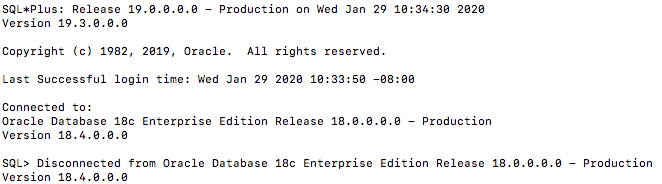

<a id='setup_12'></a>
### 12. Connect to Autonomous Database

The `ADS` `Connector` class allows you several difference different ways to connect to the database. It is integrated with the Vault and the local repository. It also accepts arguments that are passed directly to the database. However, suppling credentials in the notebook is a security risk.

To make a connection using a secret in the Vault, set the parameter `secret_id` to the secret OCID.

In [ ]:
if "secret_id" in globals():
    connector = Connector(secret_id=secret_id)
else:
    print("Skipping as it appears that you do not have secret_id configured.")

To use the repository with the `Connector` class, set the parameter `key` to the name of the repository key in the repository.

In [ ]:
if "database_name" in globals() and database_name != '<database_name>':
    connector = Connector(key=database_name)
else:
    print("Skipping as it appears that you do not have database_name configured.")

It is also possible to hard code connection information into the `Connector` constructor to make a connection.

In [ ]:
if credential['database_name'] != '<database_name>' and \
   credential['username'] != '<user_name>' and \
   credential['password'] != '<password>':
    connector = Connector(database_name=credential['database_name'],
                          username=credential['username'], 
                          password=credential['password'],
                          database_type=credential['database_type'])

The `config` attribute returns a dictionary of the configuration settings that were used to make the connection.

In [ ]:
if "connector" in globals():
    print(connector.config)
else:
    print("Skipping as it appears that you do not have connector configured.")

When the `Connector` object is created it will make a connection to the database. If this connection is lost, the `connect()` method can be used to re-establish the connection.

In [ ]:
if "connector" in globals():
    connector.connect()
else:
    print("Skipping as it appears that you do not have connector configured.")

<a id='load'></a>
# Loading an ADB Table as an `ADSDataset` Object   

Now that there is a connection to ADB, it can be queried. In principle, this process only needs to be completed once. Before querying the database, load the credentials file content into memory. 

The next step is to test the connection by pulling a table, and then load that table as an `ADSDataset` object through `DatasetFactory`. 

By default, the ADB comes with the `sales` table in the `SH` schema. If that table has been removed, you have to update the code to provide the valid name of a table in a schema that you have access to.

ADS supports the ability to query based on an arbitrary SQL expression. In the preceding example, the `table` parameter contained the schema and table to be accessed. This parameter also takes an SQL expression.

In the next cell, the database returns the total sales by customer in descending order.

In [ ]:
sql_total_sale = """
    SELECT CUST_ID, SUM(AMOUNT_SOLD) AS TOTAL_SALES 
    FROM SH.SALES 
    GROUP BY CUST_ID 
    ORDER BY SUM(AMOUNT_SOLD) DESC
    """

In [ ]:
if "connector" in globals():
    total_sale = DatasetFactory.open(connector.uri, format="sql", 
                                     table=sql_total_sale)
else:
    print("Skipping as it appears that you do not have connector configured.")

In [ ]:
if "total_sale" in globals():
    print(total_sale.head())
else:
    print("Skipping as it appears that you do not have total_sale configured.")

In [ ]:
if "total_sale" in globals():
    total_sale.show_in_notebook()
else:
    print("Skipping as it appears that you do not have total_sale configured.")

<a id='run'></a>
# Running an SQL Query on ADB Using SQLAlchemy and Pandas

`SQLAlchemy` is compatible with ADB. In the next cell, an `SQLAlchemy` `Engine` object is used to connect to the URI for the database. The `Pandas` `read_sql` method is used to run an arbitrary SQL statement.

In [ ]:
# Make a connection to the Engine and run a query
if "connector" in globals():
    engine = create_engine(connector.uri)
    sql_customers = "SELECT * FROM SH.CUSTOMERS"
    customers = pd.read_sql(sql_customers, con=engine)
    print(customers.head())

`read_sql` is a convience method around `read_sql_query` and `read_sql_table`. Both of these methods are supported. Count the products in each category:

In [ ]:
sql_category = """
    SELECT PROD_CATEGORY, COUNT(*) AS N 
    FROM SH.PRODUCTS 
    GROUP BY PROD_CATEGORY 
    ORDER BY COUNT(*) DESC
    """

if "engine" in globals():
    category = pd.read_sql_query(sql_category, con=engine)
    print(category.head())
else:
    print("Skipping as it appears that you do not have engine configured.")

Next, call the `read_sql_table` method on the products table:

In [ ]:
if "engine" in globals():
    products = pd.read_sql_table(table_name='products', con=engine, schema='SH')
    print(products.head())
else:
    print("Skipping as it appears that you do not have engine configured.")

<a id='create'></a>
# Creating a Table with `SQLAlchemy` and `Pandas` and Updating It

The preceding generic methods are all arbitrary SQL commands to be run to perform Data Manipulation Language commands to alter the data. However, a common use pattern for the data scientist is to pull data from a table, perform manipulations on it, and then push that data frame back into the database. This pattern is demonstrated by creating a table called `PRODUCT_DEMO`. If this table exists in the default schema, then change the name in the code as it is clobbered. The database user needs permissions to create and update a table.

Make a copy of the `PRODUCTS` table from the `SH` schema, and then create the table `PRODUCT_DEMO` in the default schema:

In [ ]:
if "products" in globals():
    products_demo = products.copy()
    products_demo.to_sql(name='products_demo', index=False, con=engine, if_exists='replace')
    print(products_demo.head())
else:
    print("Skipping as it appears that you do not have products configured.")

Take a look at `PROD_ID = 116` in the `products_demo` data frame. The product name and description suggests that it a pack of 5:

In [ ]:
if "products_demo" in globals():
    print(products_demo.loc[products_demo.prod_id==116])
else:
    print("Skipping as it appears that you do not have products_demo configured.")

This should be a pack of 50 so update the record in the `products_demo` data frame:

In [ ]:
if "products_demo" in globals():
    products_demo.loc[products_demo.loc[products_demo.prod_id==116].index, 'prod_name'] = 'CD-RW, High Speed Pack of 50'
    products_demo.loc[products_demo.loc[products_demo.prod_id==116].index, 'prod_desc'] = 'CD-RW, High Speed 650MB/74 Minutes, Pack of 50'
    print(products_demo.loc[products_demo.prod_id==116])
else:
    print("Skipping as it appears that you do not have products_demo configured.")

When the database is queried, it does not reflect the change because it has not been pushed back to the database:

In [ ]:
if "engine" in globals():
    pd.read_sql_query('SELECT * FROM products_demo WHERE prod_id = 116', con=engine)
else:
    print("Skipping as it appears that you do not have engine configured.")

Using the `to_sql` method the entire data frame is pushed back to the database and replaces the existing `products_demo` table. In this example, only a single record was changed. However, it is meant to illustrate that changes to a data frame can be pushed back to the database all together. This includes any updates to the data and structure of the data frame.

In [ ]:
if "products_demo" in globals():
    products_demo.to_sql(name='products_demo', index=False, con=engine, if_exists='replace')
    pd.read_sql_query('SELECT * FROM products_demo WHERE prod_id = 116', con=engine)
else:
    print("Skipping as it appears that you do not have products_demo configured.")

Drop the table that was created and close the `SQLAlchemy` `Engine` to free resources:

In [ ]:
if "engine" in globals():
    engine.execute("DROP TABLE PRODUCTS_DEMO")
    engine.dispose() 
else:
    print("Skipping as it appears that you do not have engine configured.")

<a id='query'></a>
# Querying Data from ADB Using `cx_Oracle`

The `cx_Oracle` Python extension module enables access to an Oracle Database. It conforms to the Python database API 2.0 specification with a considerable number of additions and a couple of exclusions.

Using the `cx_Oracle` library is the preferred method and there is no need to create a JDBC connection string.

In [ ]:
if credential['database_name'] != '<database_name>' and \
   credential['username'] != '<user_name>' and \
   credential['password'] != '<password>':
    connection = cx_Oracle.connect(credential['username'], 
                                   credential['password'], 
                                   credential['database_name'])
    cursor = connection.cursor()
    sql_total_sale = "SELECT CUST_ID, SUM(AMOUNT_SOLD) AS TOTAL_SALES FROM SH.SALES GROUP BY CUST_ID ORDER BY SUM(AMOUNT_SOLD) DESC"
    total_sale = cursor.execute(sql_total_sale)
    data = total_sale.fetchall()

With `fetch_all` a `list` object is returned, not a `Pandas` data frame.

In [ ]:
if "data" in globals():
    print(type(data))
else:
    print("Skipping as it appears that you do not have data configured.")

Use the standard `list` accessor techniquest to work with the data. This is the first record:

In [ ]:
if "data" in globals():
    print(data[0])
else:
    print("Skipping as it appears that you do not have data configured.")

It is good practice to close connection and cursor objects when they are not being used. This prevents the database from being locked. Close them by calling the `close` method on each object:

In [ ]:
if "cursor" in globals():
    cursor.close()
    connection.close()
else:
    print("Skipping as it appears that you do not have cursor configured.")

<a id="reference"></a>
## References
- [Oracle ADS Library documentation](https://docs.cloud.oracle.com/en-us/iaas/tools/ads-sdk/latest/index.html)
- [Oracle Autonomous Database](https://docs.cloud.oracle.com/en-us/iaas/Content/Database/Concepts/adboverview.htm)